## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

## House Prices dataset

In [109]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

### Load Datasets

In [110]:
# load dataset

data = pd.read_csv('../houseprice.csv')

In [111]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [112]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [113]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [114]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [115]:
# Join number of bathrooms in total

X_train['FullBath'] = X_train['FullBath'] + X_train['BsmtFullBath']
X_train['HalfBath'] = X_train['HalfBath'] + X_train['BsmtHalfBath']

X_test['FullBath'] = X_test['FullBath'] + X_test['BsmtFullBath']
X_test['HalfBath'] = X_test['HalfBath'] + X_test['BsmtHalfBath']


X_train.drop(['BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)
X_test.drop(['BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

discrete.remove('BsmtFullBath')
discrete.remove('BsmtHalfBath')

In [116]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Feature Engineering Pipeline

In [117]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [118]:
data[np.append(year_vars, numerical)].isnull().mean().sort_values(ascending=False)

LotFrontage      0.177397
GarageYrBlt      0.055479
MasVnrArea       0.005479
MiscVal          0.000000
ScreenPorch      0.000000
YearRemodAdd     0.000000
YrSold           0.000000
LotArea          0.000000
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtUnfSF        0.000000
TotalBsmtSF      0.000000
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
GarageArea       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
EnclosedPorch    0.000000
3SsnPorch        0.000000
YearBuilt        0.000000
dtype: float64

In [119]:
#mean of number of categories
vals = []
for i in categorical:
    vals.append(len(data[i].unique()))

np.ceil(np.mean(vals))

7.0

In [120]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind_1',
     mdi.ArbitraryNumberImputer(
        arbitrary_number=0, variables=['MasVnrArea'])),
    
    ('missing_ind_2',
     mdi.AddNaNBinaryImputer(
         variables=['LotFrontage', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.03,
                                    n_categories=7,
                                    variables=categorical)),
    ('categorical_enc',
     ce.OneHotCategoricalEncoder(top_categories=10,
                                  variables=categorical)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [121]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11481797285.962524, tolerance: 820439508.5822282
  positive)


In [122]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 521419035.4075254
train rmse: 22834.60171335435
train r2: 0.9164905388686776

test mse: 916525174.8883798
test rmse: 30274.166790985015
test r2: 0.8666312864877466


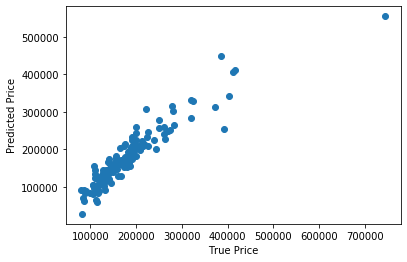

In [123]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.show()